In [ ]:
!pip install git+https://github.com/saforem2/ambivalent opinionated

  Cloning https://github.com/saforem2/ambivalent to /tmp/pip-req-build-zwldhj02
  Running command git clone --filter=blob:none --quiet https://github.com/saforem2/ambivalent /tmp/pip-req-build-zwldhj02
  Resolved https://github.com/saforem2/ambivalent to commit e130acf2ae471b2a4768dcb48e680187ce6bb716
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.8/697.8 kB 46.3 MB/s eta 0:00:00
  Created wheel for ambivalent: filename=ambivalent-0.0.1-py3-none-any.whl size=13746 sha256=d87faf7850e89e014d53107b6bbfd29474f1e93e445f43cca8f381e430c2cf1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nta4sq3z/wheels/7b/e6/96/887dca4e5d3c307c41d4cf84d23f97791a334efab8f1163d30
Successfully built ambivalent


- The dataset used: https://drive.google.com/drive/folders/1H8AB55VQrYdt6dIw4gDr-QEf87mYcnEm?usp=sharing

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import xarray as xr

import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from ambivalent import STYLES
import opinionated

In [ ]:
plt.style.use(STYLES['ambivalent'])
plt.style.use("dark_background")

In [ ]:
data = xr.open_dataset('Medium_data.nc')
data

<xarray.Dataset>
Dimensions:    (longitude: 2, latitude: 2, time: 8760)
Coordinates:
  * longitude  (longitude) float32 101.5 101.8
  * latitude   (latitude) float32 52.75 52.5
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-16 11:11:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
df = data.sel(latitude=52.53, longitude=101.63, method='pad').to_pandas().drop(['latitude', 'longitude'], axis=1)
df

,t2m,tp,sp,ssr
time,,,,
2023-01-01 00:00:00,240.185623,0.0,89905.093750,-0.125
2023-01-01 01:00:00,240.286194,0.0,89948.195312,-0.125
2023-01-01 02:00:00,241.529922,0.0,89900.945312,13952.375
2023-01-01 03:00:00,243.476532,0.0,89944.687500,163897.250
2023-01-01 04:00:00,244.894577,0.0,89860.234375,342586.125
...,...,...,...,...
2023-12-31 19:00:00,257.743073,0.0,87873.664062,-0.125
2023-12-31 20:00:00,256.389832,0.0,87842.695312,-0.125
2023-12-31 21:00:00,255.926086,0.0,87840.296875,-0.125


# 1. Line plots

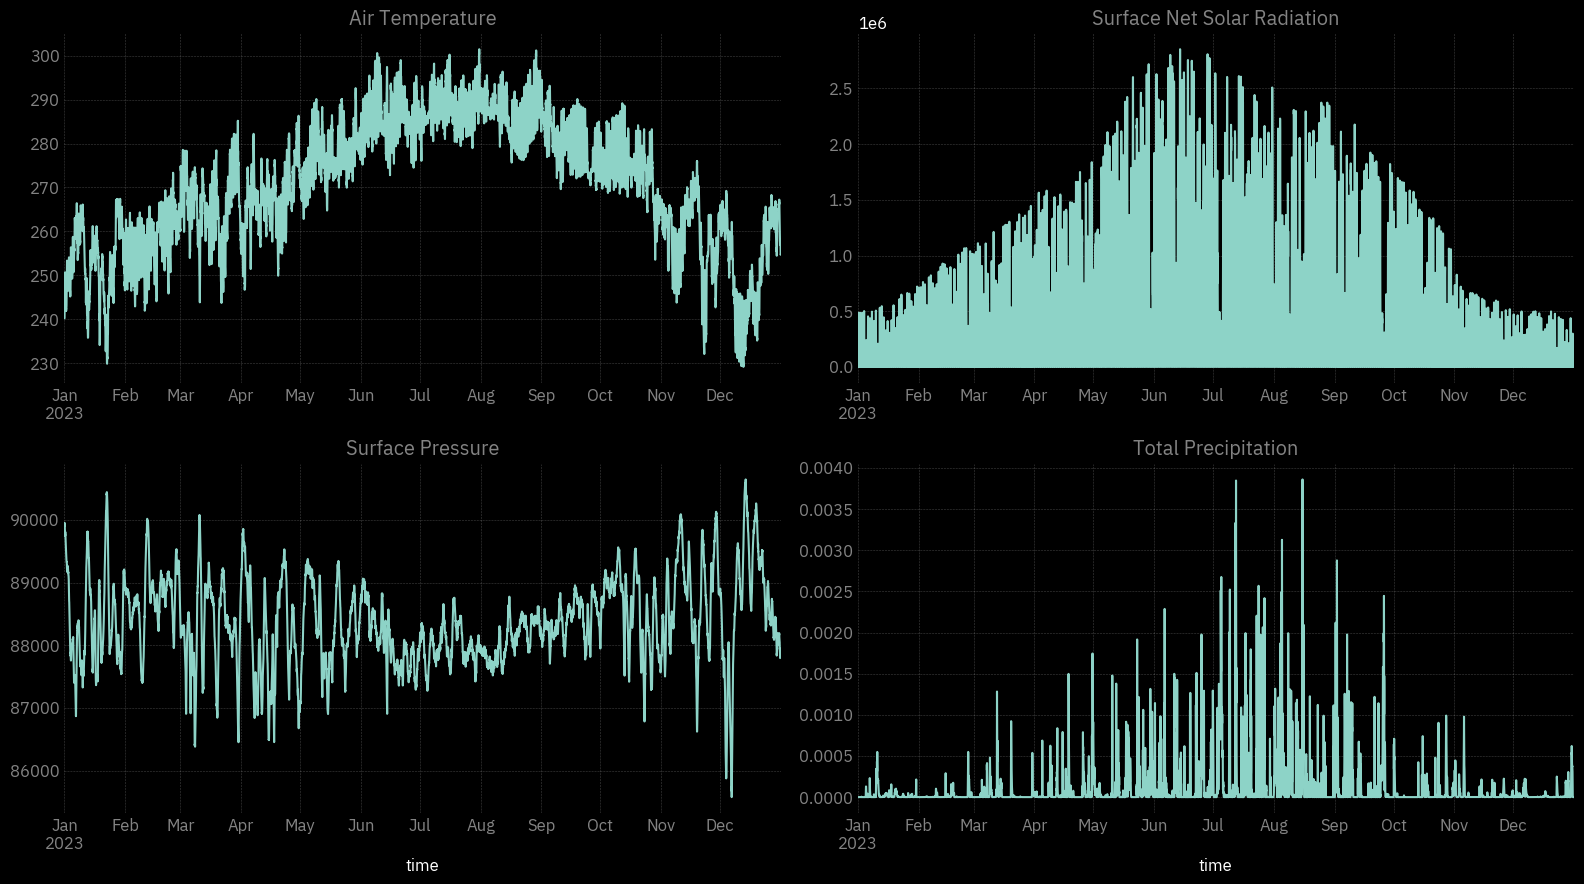

In [ ]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(16,9))
df['t2m'].plot(ax=ax[0,0])
ax[0,0].set_title('Air Temperature')
ax[0,0].set_xlabel('')
df['ssr'].plot(ax=ax[0,1])
ax[0,1].set_title('Surface Net Solar Radiation')
ax[0,1].set_xlabel('')
df['sp'].plot(ax=ax[1,0])
ax[1,0].set_title('Surface Pressure')
df['tp'].plot(ax=ax[1,1])
ax[1,1].set_title('Total Precipitation')
plt.tight_layout()
plt.show()

#2. Seasonal Decomposition and Stationarity Analysis

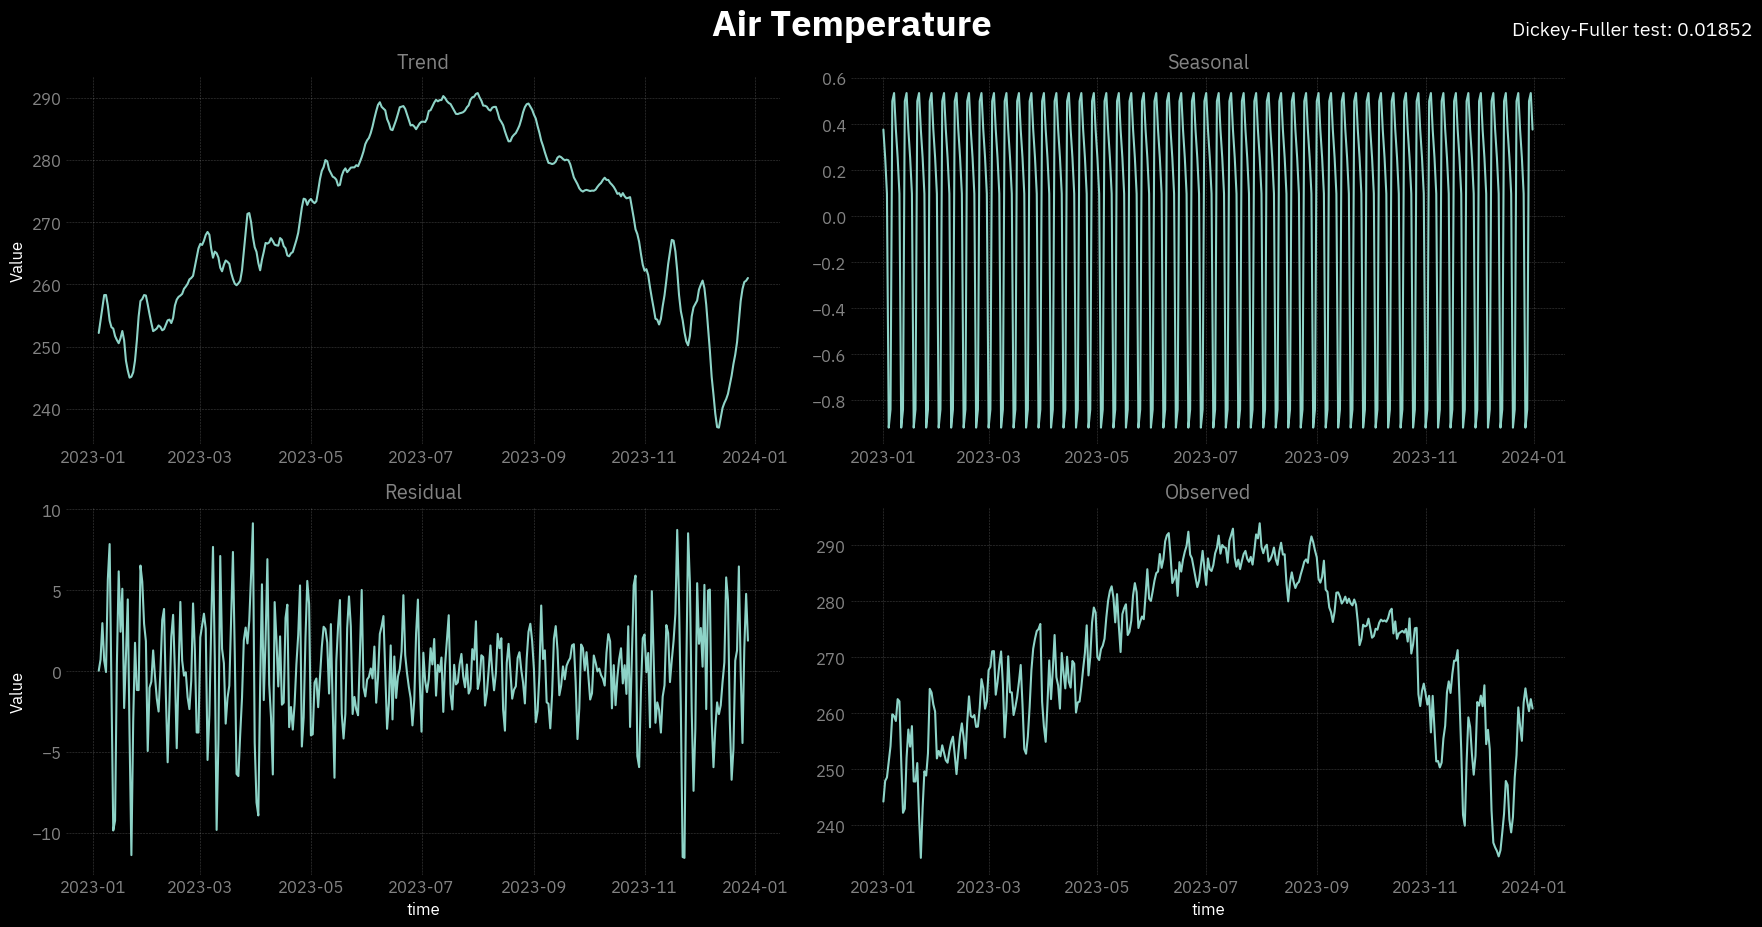

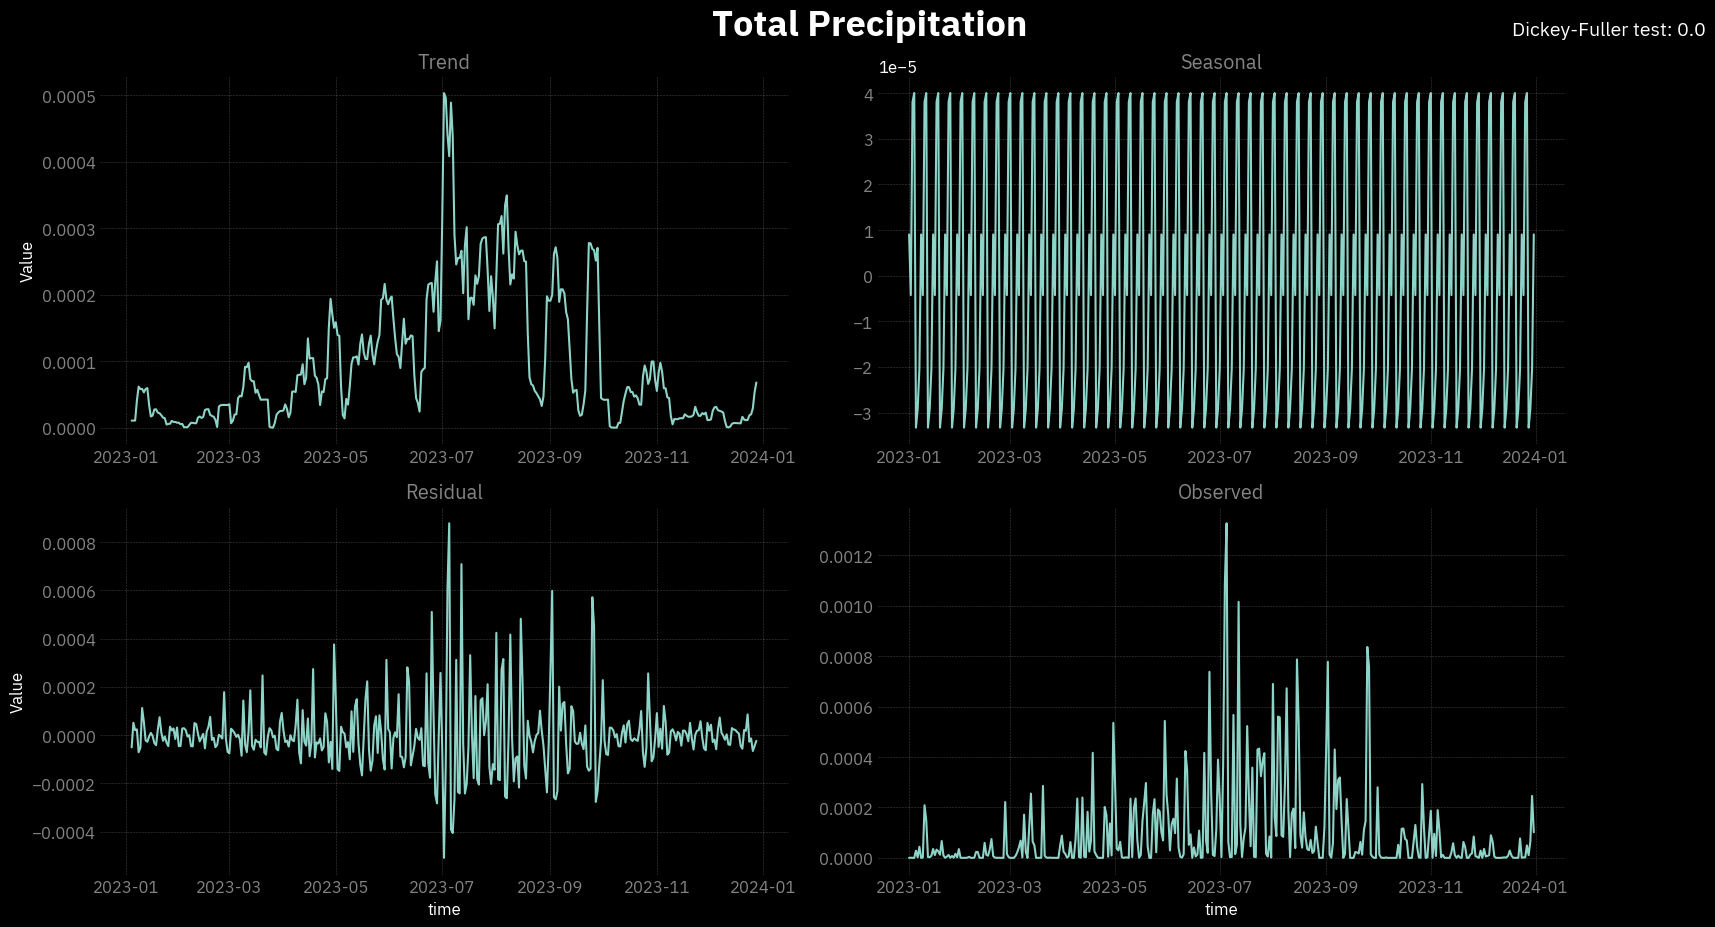

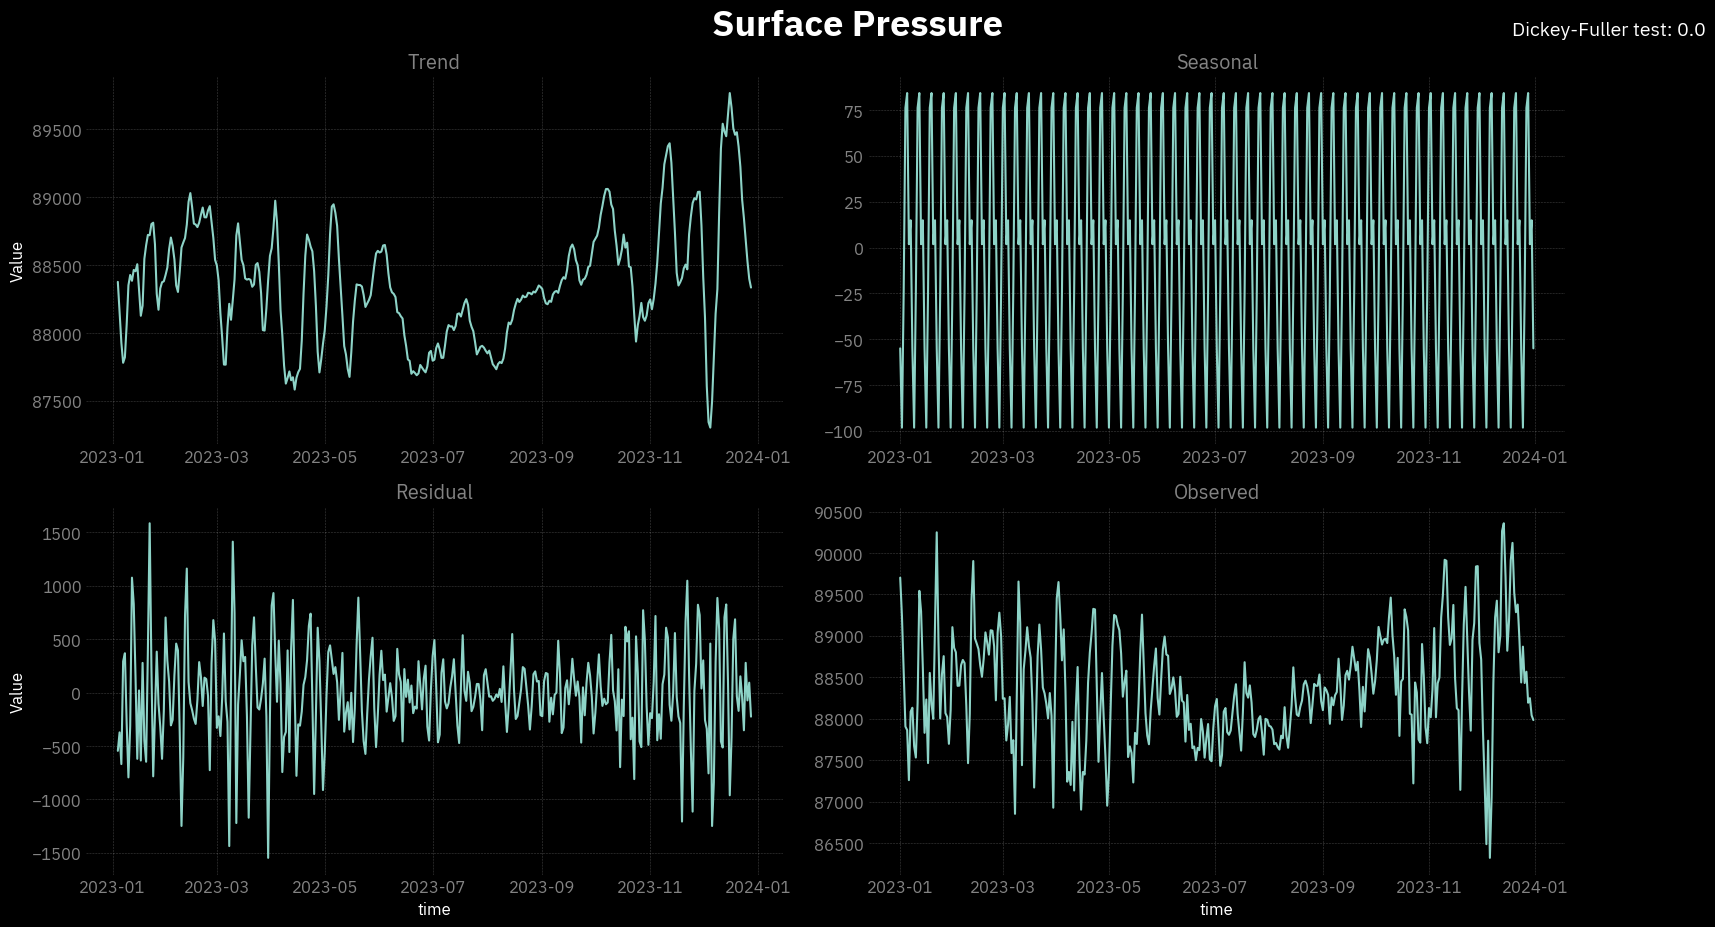

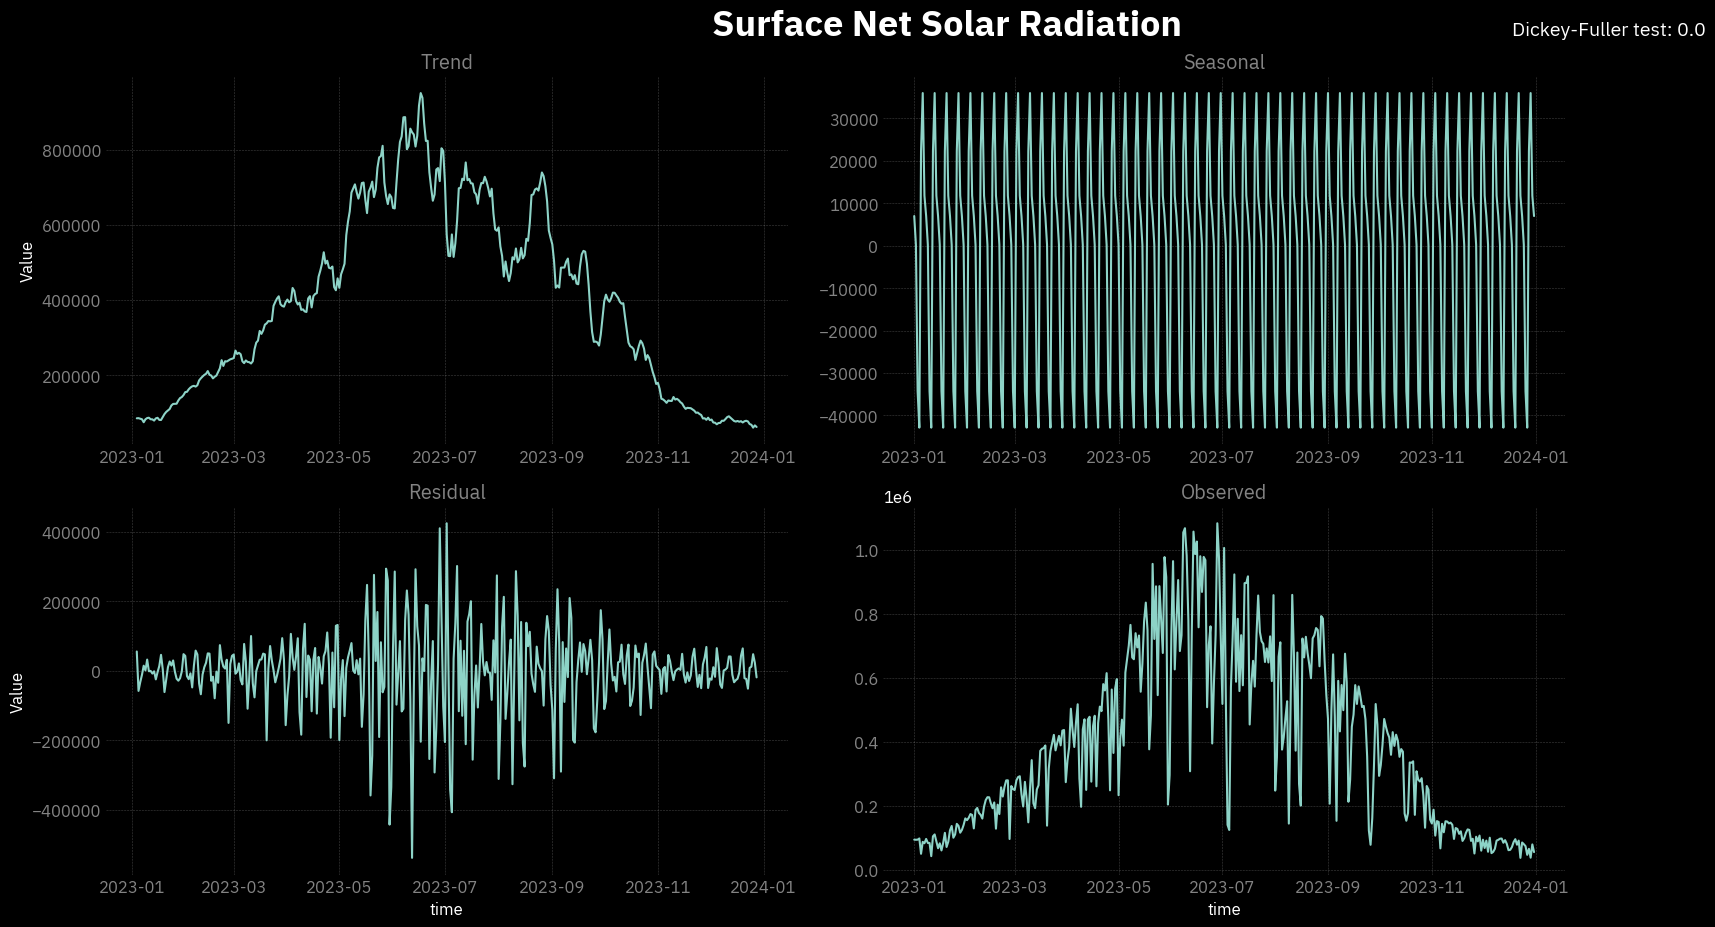

In [ ]:
vars = {'t2m': 'Air Temperature', 'tp': 'Total Precipitation', 'sp': 'Surface Pressure', 'ssr': 'Surface Net Solar Radiation'}
df_d = df.resample('1d').mean()
for var in df.columns:
  result = sm.tsa.seasonal_decompose(df_d[var], model='additive')
  results_df = pd.DataFrame({'trend': result.trend, 'seasonal': result.seasonal, 'resid': result.resid, 'observed': result.observed})
  fig, ax = plt.subplots(ncols = 2, nrows = 2,figsize=(16,9))
  ax[0,0].plot(df_d.index, results_df.trend)
  #ax[0,0].set_title(title)
  ax[0,0].set_title('Trend')
  ax[0,0].set_ylabel('Value')

  ax[0,1].plot(df_d.index, results_df.seasonal)
  ax[0,1].set_title('Seasonal')

  ax[1,0].plot(df_d.index, results_df.resid)
  ax[1,0].set_title('Residual')
  ax[1,0].set_ylabel('Value')
  ax[1,0].set_xlabel('time')

  ax[1,1].plot(df_d.index, results_df.observed)
  ax[1,1].set_title('Observed')
  ax[1,1].set_xlabel('time')

  opinionated.set_title_and_suptitle(vars[var], f"Dickey-Fuller test: {round(sm.tsa.stattools.adfuller(df[var])[1],5)}", position_title=[0.45,1],
                                     position_sub_title=[0.95, 1])
  plt.tight_layout()
  plt.savefig(f'Seasonal_{var}.png')
  plt.show()



# 3. Distributions

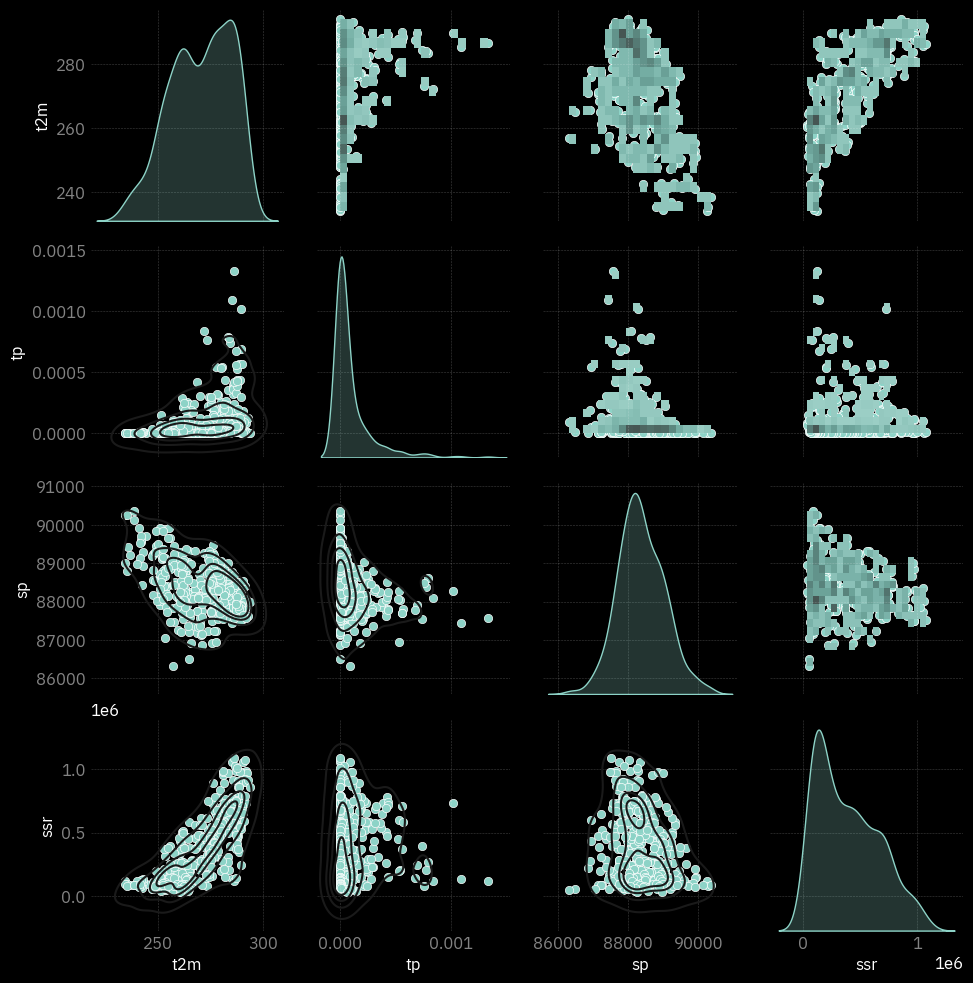

In [ ]:
ax = sns.pairplot(df_d, diag_kind='kde')
ax.map_upper(sns.histplot, bins=20)
ax.map_lower(sns.kdeplot, levels=5, color='.1')
plt.show()

# 4. Box-Cox

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Dickey-Fuller test: p=0.032869


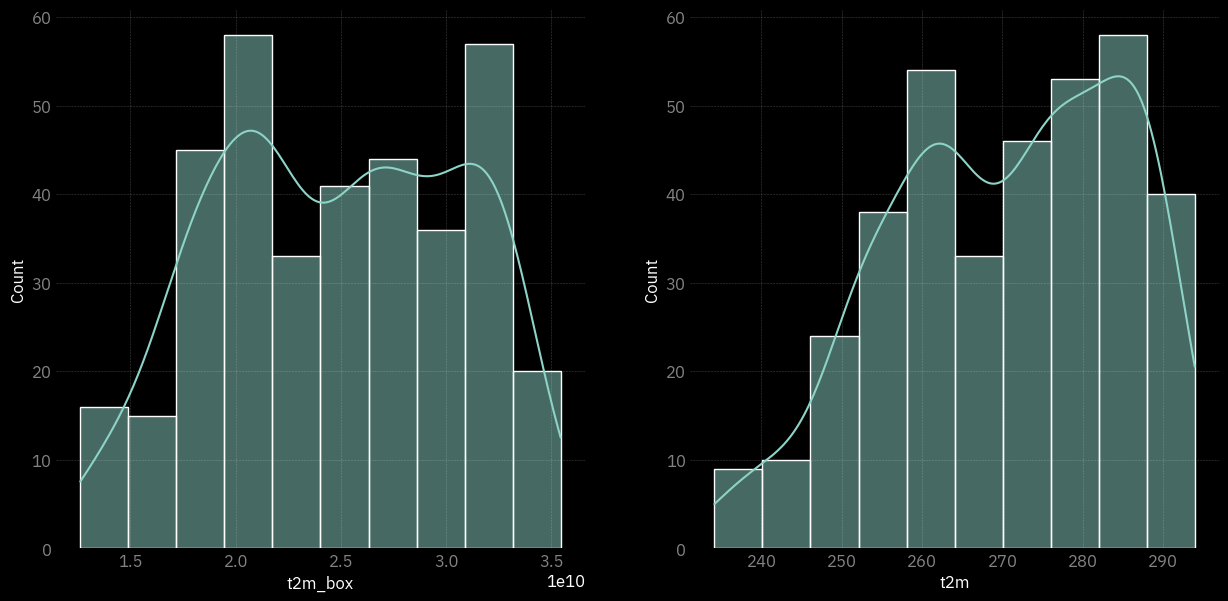

In [ ]:
df_d['t2m_box'], _ = stats.boxcox(df_d.t2m)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.histplot(df_d.t2m_box, kde=True, ax=ax[0])
sns.histplot(df_d.t2m, kde=True, ax=ax[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.t2m_box)[1])

In [ ]:
plt.rcParams['axes.prop_cycle'].by_key()['color']

['#8dd3c7',
 '#feffb3',
 '#bfbbd9',
 '#fa8174',
 '#81b1d2',
 '#fdb462',
 '#b3de69',
 '#bc82bd',
 '#ccebc4',
 '#ffed6f']

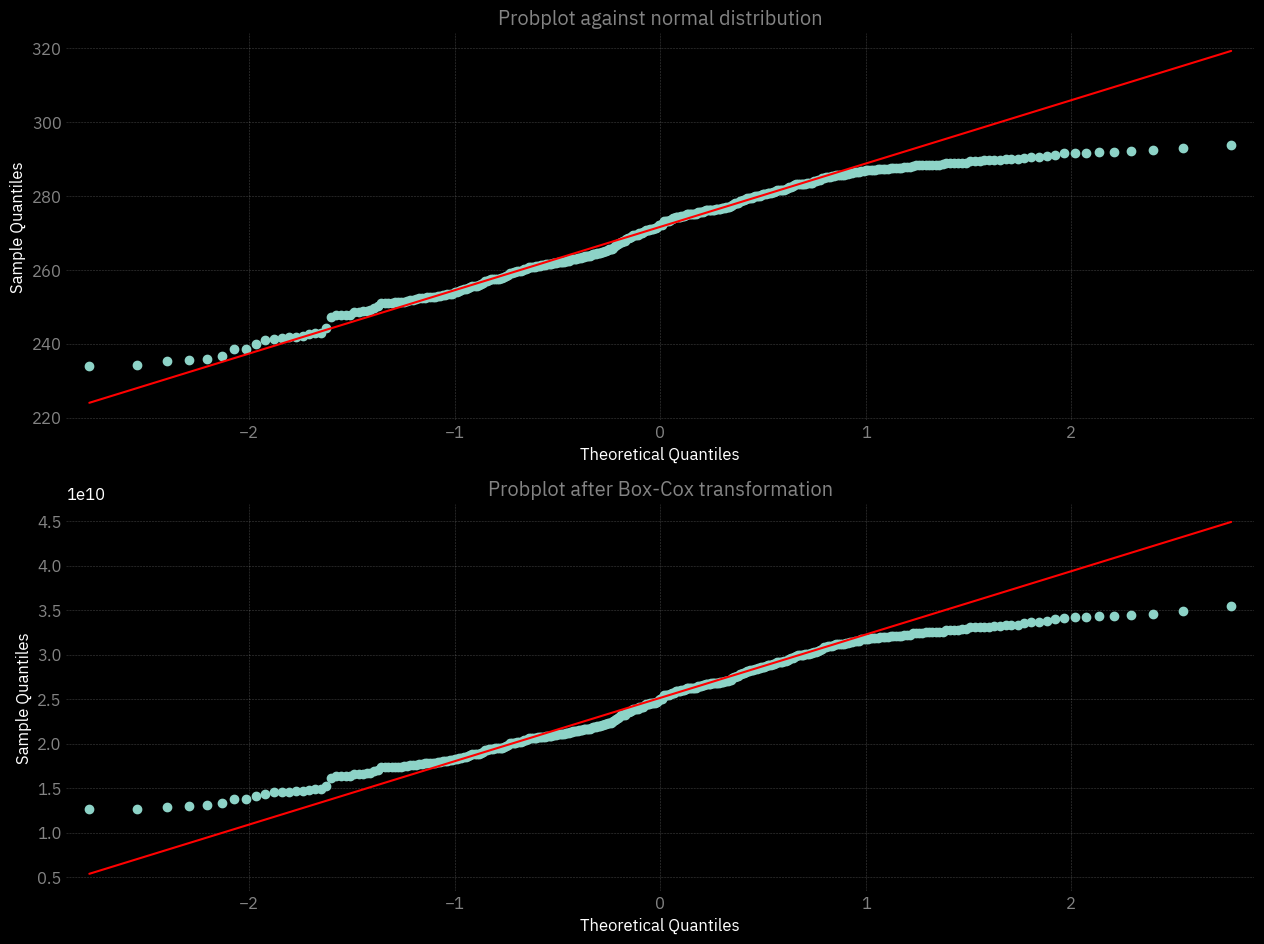

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
#prob = stats.probplot(df_d.t2m, dist=stats.norm, plot=ax1)
#ax1.get_lines()[1].set_color('w')
sm.qqplot(df_d.t2m, ax=ax1, line='q')
#ax1.get_lines()[0].set_color('#8dd3c7')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
#prob = stats.probplot(df_d.t2m_box, dist=stats.norm, plot=ax2)
sm.qqplot(df_d.t2m_box, ax=ax2, line='q')
#ax2.get_lines()[1].set_color('w')
#ax2.get_lines()[0].set_color('#8dd3c7')
ax2.set_title('Probplot after Box-Cox transformation')
plt.tight_layout()

# 5. Autocorrelation

In [ ]:
for var in df.columns[:-1]:
  fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
  plot_acf(df_d[var], ax = ax1)
  plot_pacf(df_d[var], ax = ax2)
  opinionated.set_title_and_suptitle(vars[var], '',position_title=[0.38,1],
                                     position_sub_title=[0.95, 1])
  plt.tight_layout()
  plt.show()